<a href="https://colab.research.google.com/github/Ramkanc/Capstone_IIITH/blob/Capstone1_MultiModel_V1/Capstone1_RamK_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install opencv-python==4.8.0.76

In [8]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import pandas as pd

In [9]:
import PIL
from PIL import Image

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [11]:
found_directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
found_files =[f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print (found_directories)
print (found_files)

['Images']
['captions.txt']


In [12]:
image_dir= os.path.join(path, found_directories[0])
print(image_dir)

/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images


In [14]:
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir):
        """
        Args:
            image_dir (str): Path to the directory with images.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    def preprocess_image_opencv(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")

        # Resize to 224x224
        image_resized = cv2.resize(image, (224, 224))

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image_normalized = image_rgb / 255.0

        # Reshape to CxHxW
        image_reshaped = np.transpose(image_normalized, (2, 0, 1))

        # Convert to PyTorch tensor
        image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

        # Normalize using ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std

        return image_tensor

    def __len__(self):
        # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        image_file_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file_name)

        # Preprocess the image
        image_tensor = self.preprocess_image_opencv(image_path)

        # Extract image ID (filename without extension)
        image_id = os.path.splitext(image_file_name)[0]

        # Return the processed tensor
        return image_tensor,image_id

In [16]:
# Create an instance of the custom dataset
dataset = CustomImageDataset(image_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [17]:
# Iterate over the DataLoader
for batch_idx, batch_images in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Shape: {batch_images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Type: {batch_images.dtype}")  # Expected: torch.float32
    break

Batch 1:
Shape: torch.Size([32, 3, 224, 224])
Type: torch.float32


In [18]:
# Function to display a single image
def show_image(image_tensor):
    # Undo normalization for display (optional if you want raw pixel values)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Denormalize

    # Convert from Tensor (CxHxW) to NumPy array (HxWxC)
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip values to [0, 1] for proper display

    # Display the image
    plt.imshow(image_numpy)
    plt.axis('off')

In [19]:
def display_images_from_dataloader(dataloader, dataset, num_images=10):
    images_shown = 0
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

    # Get the image file names from the dataset
    image_files = dataset.image_files

    for batch_idx, batch_images in enumerate(dataloader):
        for image_idx, image_tensor in enumerate(batch_images):
            if images_shown >= num_images:
                break

            # Get the corresponding image file name for the current image
            image_file_name = image_files[batch_idx * dataloader.batch_size + image_idx]

            plt.subplot(2, 5, images_shown + 1)  # Create a 2x5 grid for 10 images
            show_image(image_tensor)
            plt.title(image_file_name)  # Set the image file name as the title
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

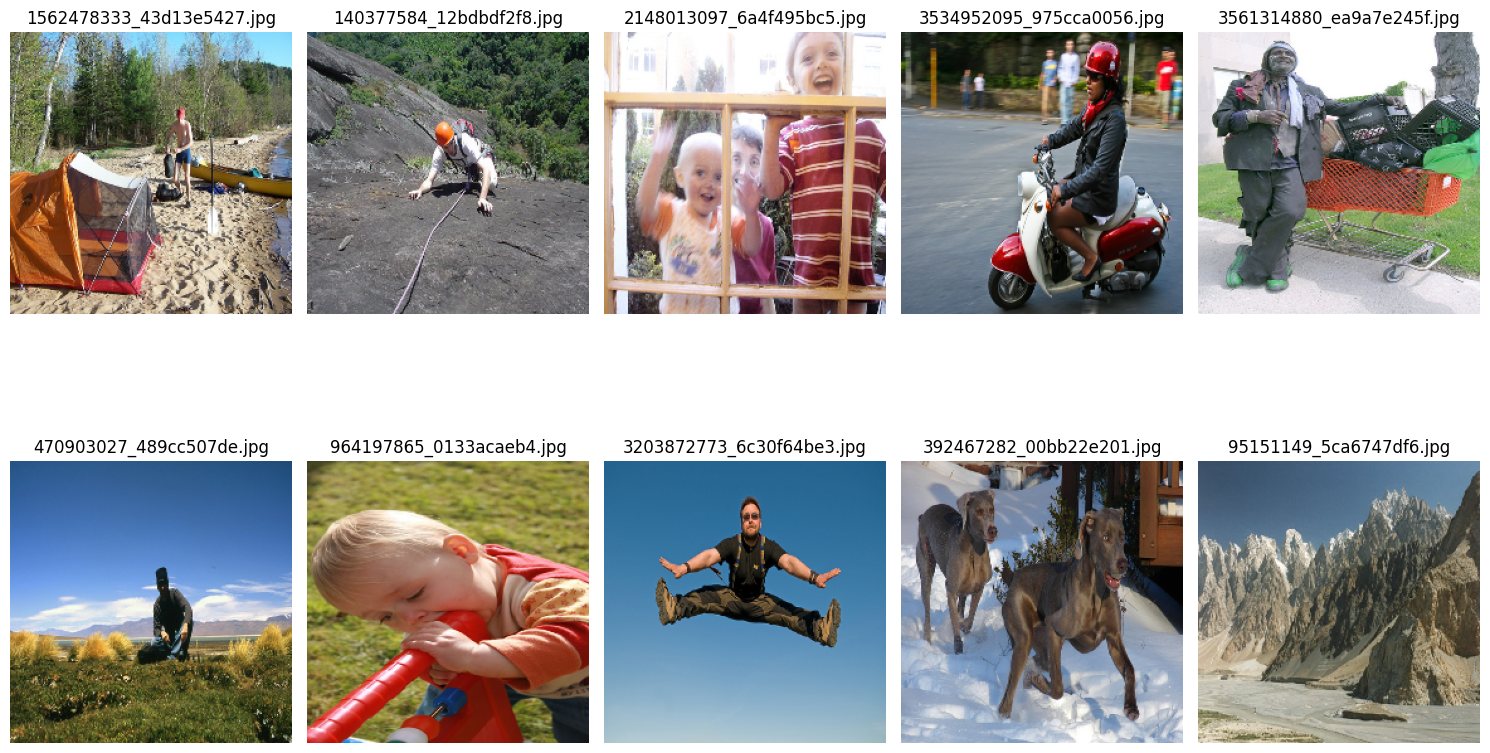

In [20]:
# Call the function to display images
display_images_from_dataloader(dataloader, dataset, num_images=10)

In [21]:
labels_file = os.path.join(path, found_files[0])

In [22]:
# for line in open(labels_file, 'r'):
#     print(line)

In [28]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width

In [29]:
raw_captions = pd.read_csv(labels_file, delimiter=',',header=0)

In [30]:
raw_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [31]:
concatenated_df= raw_captions.groupby('image')['caption'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

In [32]:
concatenated_df.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .


In [33]:
concatenated_df['caption_word_count'] = concatenated_df['caption'].apply(lambda x: len(x.split()))

In [34]:
concatenated_df.head()

,image,caption,caption_word_count
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .,58
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .,65
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . A little girl is sitting in front of a large painted rainbow . A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . There is a girl with pigtails sitting in front of a rainbow painting . Young girl with pigtails painting outside in the grass .,78
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him . A man lays on the bench to which a white dog is also tied . a man sleeping on a bench outside with a white and black dog sitting next to him . A shirtless man lies on a park bench with his dog . man laying on bench holding leash of dog sitting on ground,69
4,1007129816_e794419615.jpg,A man in an orange hat starring at something . A man wears an orange hat and glasses . A man with gauges and glasses is wearing a Blitz hat . A man with glasses is wearing a beer can crocheted hat . The man with pierced ears is wearing glasses and an orange hat .,56


In [36]:
max_word_count = concatenated_df['caption_word_count'].max()
print("Maximum caption word count:", max_word_count)

Maximum caption word count: 104


In [ ]:
from transformers import BertTokenizer
import re

In [39]:
from transformers import BertTokenizer

def preprocess_text(text):
    """
    Preprocesses the caption text.

    Args:
        text (str): The caption text.

    Returns:
        str: The preprocessed caption text.
    """
    # Lowercase the text
    text = text.lower()

    # Remove punctuation (fixed regex for removing special characters)
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    # Add special tokens for start and end of sequence
    text = "[CLS] " + text + " [SEP]"

    return text

In [40]:
def tokenize_text(text, tokenizer, max_length=104):
    """
    Tokenizes the preprocessed caption text using BertTokenizer.

    Args:
        text (str): The preprocessed caption text.
        tokenizer (transformers.BertTokenizer): The tokenizer object.
        max_length (int): Maximum length for tokenized captions.

    Returns:
        list: A list of token IDs padded to max_length.
    """
    # Tokenize the text with padding and truncation
    tokenized_output = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return tokenized_output["input_ids"].squeeze(0)  # Remove batch dimension

In [41]:
# Create a BertTokenizer instance
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# data
captions = concatenated_df['caption'].tolist()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Preprocess and tokenize each caption
for caption in captions:
    preprocessed_caption = preprocess_text(caption)
    token_ids = tokenize_text(preprocessed_caption, tokenizer)

    #print("Original Caption:", caption)
    #print("Preprocessed Caption:", preprocessed_caption)
    #print("Token IDs:", token_ids.tolist())  # Convert tensor to list for readability
    #print("-" * 20)

Streaming output truncated to the last 5000 lines.
Original Caption: A brown dog is running through a brown field .
Preprocessed Caption: [CLS] a brown dog is running through a brown field  [SEP]
Token IDs: [101, 101, 1037, 2829, 3899, 2003, 2770, 2083, 1037, 2829, 2492, 102, 102, 0, 0, 0, 0, 0, 0, 0]
--------------------
Original Caption: A brown dog is running through the field .
Preprocessed Caption: [CLS] a brown dog is running through the field  [SEP]
Token IDs: [101, 101, 1037, 2829, 3899, 2003, 2770, 2083, 1996, 2492, 102, 102, 0, 0, 0, 0, 0, 0, 0, 0]
--------------------
Original Caption: A brown dog with a collar runs in the dead grass with his tongue hanging out to the side .
Preprocessed Caption: [CLS] a brown dog with a collar runs in the dead grass with his tongue hanging out to the side  [SEP]
Token IDs: [101, 101, 1037, 2829, 3899, 2007, 1037, 9127, 3216, 1999, 1996, 2757, 5568, 2007, 2010, 4416, 5689, 2041, 2000, 102]
--------------------
Original Caption: a brown dog w